### Basic Libraries

In [1]:
import json
import statistics
import math

from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

sb.set()

import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
anime_df = pd.read_csv('D:\\Study Work\\Data Science\\Data Science Projects\\Otaku\\data\\anime_cleaned.csv')
print("Number of animes:", len(anime_df))
anime_df.head(1)

Number of animes: 7814


,id,title,start_date,synopsis,mean,popularity,num_list_users,num_scoring_users,nsfw,media_type,...,start_season_year,start_season_season,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,positive_viewership_fraction,negative_viewership_fraction
0,21,One Piece,1999-10-20,Barely surviving in a barrel after passing thr...,8.72,17,2463199,1398717,white,tv,...,1999.0,fall,1746533.0,16.0,297039.0,195959.0,223517.0,2463064.0,0.7998,0.2002


### Dropping non important features

In [3]:
anime_df.drop([
    'title', 'start_date', 'end_date', 'id', 'synopsis',
    'num_list_users', 'num_scoring_users', 'broadcast_day_of_the_week',
    'broadcast_start_time', 'statistics_watching', 'statistics_completed',
    'statistics_on_hold', 'statistics_dropped', 'statistics_plan_to_watch',
    'statistics_num_list_users', 'negative_viewership_fraction'
],
              axis=1,
              inplace=True)

* 0: Not Successful
* 1: Successful: Top 500 popularity, mean above 8.5, positive_viewership_fraction above 0.975

In [4]:
len(anime_df[anime_df['positive_viewership_fraction'] >= 0.975]['positive_viewership_fraction'])

910

In [6]:
# Ensure the relevant columns are numeric
anime_df['mean'] = pd.to_numeric(anime_df['mean'], errors='coerce')
anime_df['popularity'] = pd.to_numeric(anime_df['popularity'], errors='coerce')
anime_df['positive_viewership_fraction'] = pd.to_numeric(anime_df['positive_viewership_fraction'], errors='coerce')

# Create 'success' column
anime_df['success'] = np.nan

for row in range(len(anime_df)):
    success = (anime_df['popularity'][row] <= 500 or
               anime_df['mean'][row] >= 8.5 or
               anime_df['positive_viewership_fraction'][row] >= 0.975)
    
    if success:
        anime_df['success'][row] = 1
    else:
        anime_df['success'][row] = 0


In [7]:
anime_df.head()

,mean,popularity,nsfw,media_type,status,genres,num_episodes,source,average_episode_duration,rating,studios,season,year,start_season_year,start_season_season,positive_viewership_fraction,success
0,8.72,17,white,tv,currently_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",0,manga,1440,pg_13,"[{'id': 18, 'name': 'Toei Animation'}]",winter,2000,1999.0,fall,0.7998,1.0
1,8.06,4962,white,ova,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 50, 'name...",28,novel,1560,r,"[{'id': 1269, 'name': 'K-Factory'}]",winter,2000,1999.0,fall,0.9455,0.0
2,7.78,5063,white,tv,finished_airing,"[{'id': 50, 'name': 'Adult Cast'}, {'id': 4, '...",373,manga,1500,pg_13,"[{'id': 36, 'name': 'Gallop'}]",winter,2000,1996.0,summer,0.8507,0.0
3,8.42,373,white,tv,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",62,manga,1380,pg_13,"[{'id': 22, 'name': 'Nippon Animation'}]",winter,2000,1999.0,fall,0.9255,1.0
4,8.68,218,white,tv,finished_airing,"[{'id': 4, 'name': 'Comedy'}, {'id': 55, 'name...",43,manga,1550,r,"[{'id': 1, 'name': 'Pierrot'}]",winter,2000,1999.0,summer,0.9132,1.0


In [8]:
print("Number of not successful animes:", len(anime_df[anime_df['success'] == 0]['success']))
print("Number of successful animes:\t", len(anime_df[anime_df['success'] == 1]['success']))

Number of not successful animes: 6265
Number of successful animes:	 1549


### Unravel genres and studios from one column to multiple columns

In [9]:
### FOR THE REVIEWS COLUMN AS THE DATA IS FLOAT
def json_studios_float(data_clean):
    # Convert studios string to json
    for row in range(0, len(data_clean)):
        studio_data = data_clean['studios'][row]
        
        if not studio_data:  # Skip empty or None values
            data_clean['studios'][row] = None
            continue
        
        if isinstance(studio_data, list):  # If it's already a list, no need to parse
            data_clean['studios'][row] = studio_data
            continue
        
        # Ensure studio_data is a string before attempting to replace
        if isinstance(studio_data, str):
            try:
                studios = json.loads(studio_data.replace("'", "\""))
            except json.JSONDecodeError:
                try:
                    # Attempt to fix potential common formatting errors
                    studios = json.loads(studio_data.replace("'", "\"").replace("\"s", "'s").replace('N\"', "N\'"))
                except json.JSONDecodeError as e:
                    print(f"JSONDecodeError at row {row}: {studio_data}")  # Log the error and data for debugging
                    data_clean['studios'][row] = None
                    continue  # Continue with the next row
        else:
            data_clean['studios'][row] = None  # Handle non-string values, like floats, as None
        
        data_clean['studios'][row] = studios
    
    return data_clean

def json_genres(data_clean):
    # Convert genres string to json
    for row in range(0, len(data_clean)):
        genre_str = data_clean['genres'][row]
        
        # If it's a list, convert it directly
        if isinstance(genre_str, list):
            data_clean['genres'][row] = genre_str
        elif isinstance(genre_str, str):
            # If it's a string, replace single quotes with double quotes and convert to JSON
            genre_str = genre_str.replace("'", "\"")
            # Check for empty strings or invalid JSON format
            if genre_str.strip():
                try:
                    genres = json.loads(genre_str)
                    data_clean['genres'][row] = genres
                except json.JSONDecodeError:
                    print(f"Invalid JSON format at row {row}: {genre_str}")
            else:
                print(f"Empty string at row {row}")
        else:
            print(f"Unexpected type at row {row}: {type(genre_str)}")
                
    return data_clean


In [10]:
# convert to json
anime_df = json_studios_float(anime_df)
anime_df = json_genres(anime_df)

Invalid JSON format at row 6325: finished_airing
Invalid JSON format at row 6592: finished_airing
Invalid JSON format at row 7090: finished_airing


In [11]:
invalid_indices = [6325, 6592, 7090]
anime_df = anime_df.drop(index=invalid_indices)
anime_df.reset_index(drop=True, inplace=True)

In [31]:
anime_df.head(2)

,mean,popularity,nsfw,media_type,status,genres,num_episodes,source,average_episode_duration,rating,studios,season,year,start_season_year,start_season_season,positive_viewership_fraction,success
0,8.72,17,white,tv,currently_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",0,manga,1440,pg_13,"[{'id': 18, 'name': 'Toei Animation'}]",winter,2000,1999.0,fall,0.7998,1.0
1,8.06,4962,white,ova,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 50, 'name...",28,novel,1560,r,"[{'id': 1269, 'name': 'K-Factory'}]",winter,2000,1999.0,fall,0.9455,0.0


### Feature Eng. and Modelling

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

In [48]:
def prepare_features(df):
    """
    Prepare features for classification with proper type handling
    """
    df_clean = df.copy()
    
    numeric_cols = ['mean', 'popularity', 'num_episodes', 
                   'average_episode_duration', 'start_season_year',
                   'positive_viewership_fraction']
    
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    df_clean['genre_count'] = df_clean['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df_clean['studio_count'] = df_clean['studios'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    categorical_cols = ['media_type', 'status', 'rating', 'season', 
                       'start_season_season', 'nsfw']
    df_encoded = pd.get_dummies(df_clean[categorical_cols], prefix=categorical_cols)
    
    numeric_features = ['mean', 'popularity', 'num_episodes', 
                       'average_episode_duration', 'start_season_year',
                       'positive_viewership_fraction', 'genre_count', 
                       'studio_count']
    
    features = pd.concat([
        df_clean[numeric_features],
        df_encoded
    ], axis=1)
    
    return features.dropna()

In [49]:
def train_models_with_cv(X, y):
    """
    Train Decision Tree and Random Forest models with cross-validation and hyperparameter tuning
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                       test_size=0.2, 
                                                       random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameter grids for each model
    dt_param_grid = {
        'max_depth': [5, 7, 9, 11],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 9, 11],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    
    # Initialize base models
    dt_model = DecisionTreeClassifier(random_state=42)
    rf_model = RandomForestClassifier(random_state=42)
    
    # Perform GridSearchCV for both models
    dt_grid = GridSearchCV(
        estimator=dt_model,
        param_grid=dt_param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    rf_grid = GridSearchCV(
        estimator=rf_model,
        param_grid=rf_param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit models
    print("Training Decision Tree...")
    dt_grid.fit(X_train_scaled, y_train)
    
    print("\nTraining Random Forest...")
    rf_grid.fit(X_train_scaled, y_train)
    
    return {
        'models': {
            'decision_tree': dt_grid.best_estimator_,
            'random_forest': rf_grid.best_estimator_
        },
        'best_params': {
            'decision_tree': dt_grid.best_params_,
            'random_forest': rf_grid.best_params_
        },
        'scaler': scaler,
        'data': {
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test
        }
    }

In [50]:
try:
    # Prepare features
    X = prepare_features(anime_df)
    y = anime_df.loc[X.index, 'success']
    
    print("Shape of features:", X.shape)
    print("\nFeature columns:", X.columns.tolist())
    
    # Train models
    results = train_models_with_cv(X, y)
    
    # Print best parameters
    print("\nBest Parameters:")
    print("Decision Tree:", results['best_params']['decision_tree'])
    print("Random Forest:", results['best_params']['random_forest'])

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please check your DataFrame columns and data types:")
    print(anime_df.dtypes)

Shape of features: (7809, 36)

Feature columns: ['mean', 'popularity', 'num_episodes', 'average_episode_duration', 'start_season_year', 'positive_viewership_fraction', 'genre_count', 'studio_count', 'media_type_cm', 'media_type_movie', 'media_type_music', 'media_type_ona', 'media_type_ova', 'media_type_pv', 'media_type_special', 'media_type_tv', 'media_type_tv_special', 'status_currently_airing', 'status_finished_airing', 'rating_g', 'rating_no_rating', 'rating_pg', 'rating_pg_13', 'rating_r', 'rating_r+', 'season_ Japan Media Arts Festival for Animation Division - Excellence Award in 2017', 'season_fall', 'season_spring', 'season_summer', 'season_winter', "season_{'status': {'watching': '87', 'completed': '195', 'on_hold': '39', 'dropped': '125', 'plan_to_watch': '559'}, 'num_list_users': 1005}", 'start_season_season_fall', 'start_season_season_spring', 'start_season_season_summer', 'start_season_season_winter', 'nsfw_white']
Training Decision Tree...
Fitting 5 folds for each of 72 ca

### Evaluation

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [55]:
def plot_confusion_matrices(y_true, y_pred_dt, y_pred_rf):
    """Plot confusion matrices for both models"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Decision Tree Confusion Matrix
    cm_dt = confusion_matrix(y_true, y_pred_dt)
    sns.heatmap(cm_dt, annot=True, fmt='d', ax=ax1, cmap='Blues')
    ax1.set_title('Decision Tree Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    # Random Forest Confusion Matrix
    cm_rf = confusion_matrix(y_true, y_pred_rf)
    sns.heatmap(cm_rf, annot=True, fmt='d', ax=ax2, cmap='Blues')
    ax2.set_title('Random Forest Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    
    plt.tight_layout()
    plt.show()

def create_metrics_df(y_true, y_pred_dt, y_pred_rf):
    """Create DataFrame with all metrics"""
    metrics = {
        'Model': ['Decision Tree', 'Random Forest'],
        'Accuracy': [
            accuracy_score(y_true, y_pred_dt),
            accuracy_score(y_true, y_pred_rf)
        ],
        'Precision': [
            precision_score(y_true, y_pred_dt),
            precision_score(y_true, y_pred_rf)
        ],
        'Recall': [
            recall_score(y_true, y_pred_dt),
            recall_score(y_true, y_pred_rf)
        ],
        'F1 Score': [
            f1_score(y_true, y_pred_dt),
            f1_score(y_true, y_pred_rf)
        ]
    }
    
    return pd.DataFrame(metrics).set_index('Model').round(4)

In [56]:
y_true = results['data']['y_test']
dt_model = results['models']['decision_tree']
rf_model = results['models']['random_forest']
X_test = results['data']['X_test']

y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

Confusion Matrices:


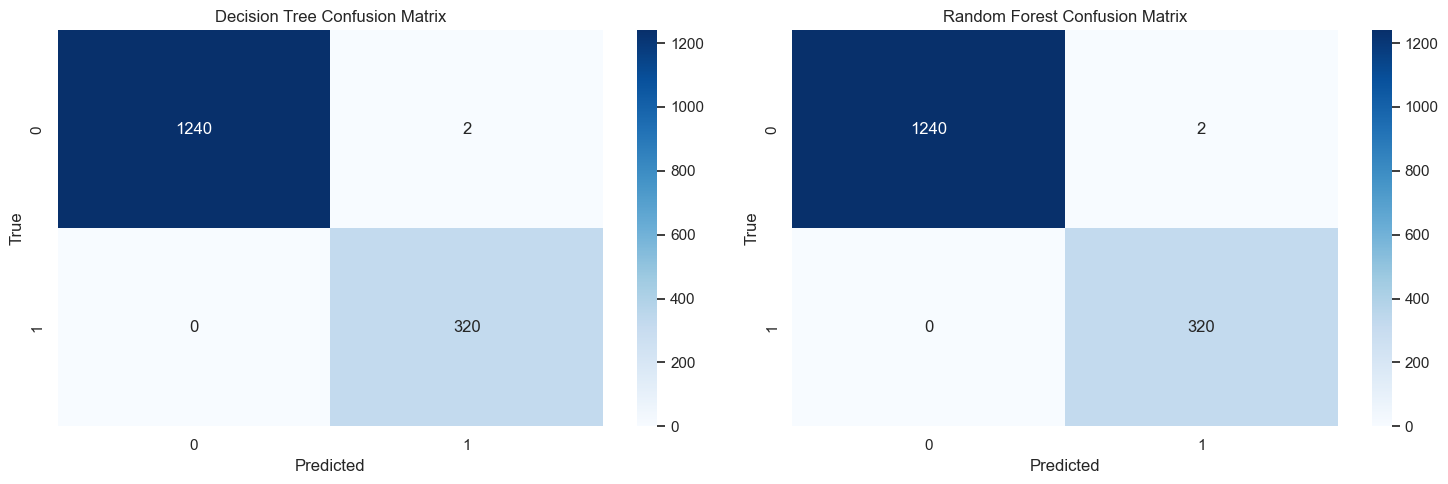

In [57]:
print("Confusion Matrices:")
plot_confusion_matrices(y_true, y_pred_dt, y_pred_rf)

In [59]:
print("Model Performance Metrics:")
metrics_df = create_metrics_df(y_true, y_pred_dt, y_pred_rf)
metrics_df

Model Performance Metrics:


,Accuracy,Precision,Recall,F1 Score
Model,,,,
Decision Tree,0.9987,0.9938,1.0,0.9969
Random Forest,0.9987,0.9938,1.0,0.9969
